# Классификация токсичных комментариев

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Критерии: метрика качества *F1* не меньше 0.75.

**Описание данных**

Столбец *text* содержит текст комментария, а *toxic* — целевой признак.

## Подготовка данных

In [ ]:
from io import BytesIO
import requests
from tqdm import notebook
import re
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

import transformers
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import torch
from torcheval.metrics import BinaryF1Score, BinaryAccuracy
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsampler import ImbalancedDatasetSampler

import optuna


RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

nltk.download('stopwords')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device(type='cuda', index=0)

In [ ]:
import warnings


warnings.filterwarnings('ignore')

### Загрузка и изучение

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1lkNJQ5n2H_V5jQOPaOiw_Tcp5dAnCODW1wQCzLbveHY/edit?usp=drive_link'
spreadsheet_id = url.split('/')[-2]
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content), index_col=[0])

In [ ]:
data = df.copy()
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
data.sample(10)

,text,toxic
153584,bite me \n\nthat is all. cunt198.111.56.230,1
32376,"""\n\nActually, im certain this will be the las...",0
38704,"""\n\nI protest not for the sake of arguing but...",0
38018,It also just now occurs to me I didn't mention...,0
72036,Keep There's an entire category for US weekday...,0
83899,I read this book shortly after it came out...I...,0
140748,William M. Connolley I have seen what has happ...,0
56245,2007 (UTC)\n\nYour continued rudeness and fail...,1
157693,"""\n\n Fullmetal Particle Man \n\nAnother Youtu...",0
21,"""\nGood to know. About me, yeah, I'm studying ...",0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [ ]:
data.reset_index(drop=True, inplace=True)

**Пропуски отсутствуют.**

In [ ]:
balance = data['toxic'].value_counts() / data.shape[0]
balance

0    0.898388
1    0.101612
Name: toxic, dtype: float64

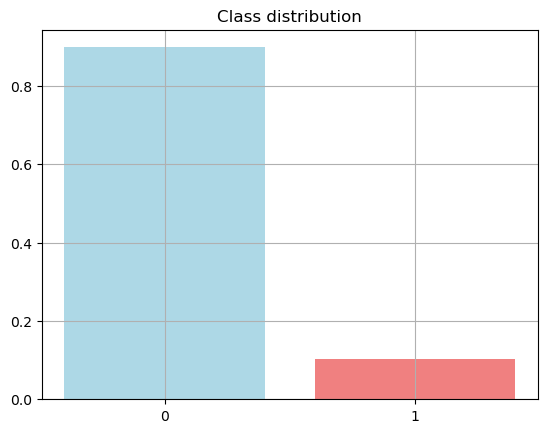

In [ ]:
plt.bar(x=balance.index, height=balance, color=['lightblue', 'lightcoral'], tick_label=balance.index)
plt.title('Class distribution')
plt.grid()
plt.show()

**Есть дисбаланс классов.**

**Посмотрим на количество слов в комментариях**

In [ ]:
def analyze_words_number(data):
    text_len = data.apply(lambda x: len(x.split())).values
    print(f'Max number of word: {text_len.max()}\n')
    print('Text with max len')
    print(np.argmax(text_len))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Number of words in text')
    sns.distplot(text_len, bins=100, ax=ax1)
    sns.boxplot(text_len, ax=ax2)
    ax1.grid()
    ax2.grid()
    plt.show()

Max number of word: 1411

Text with max len
140651


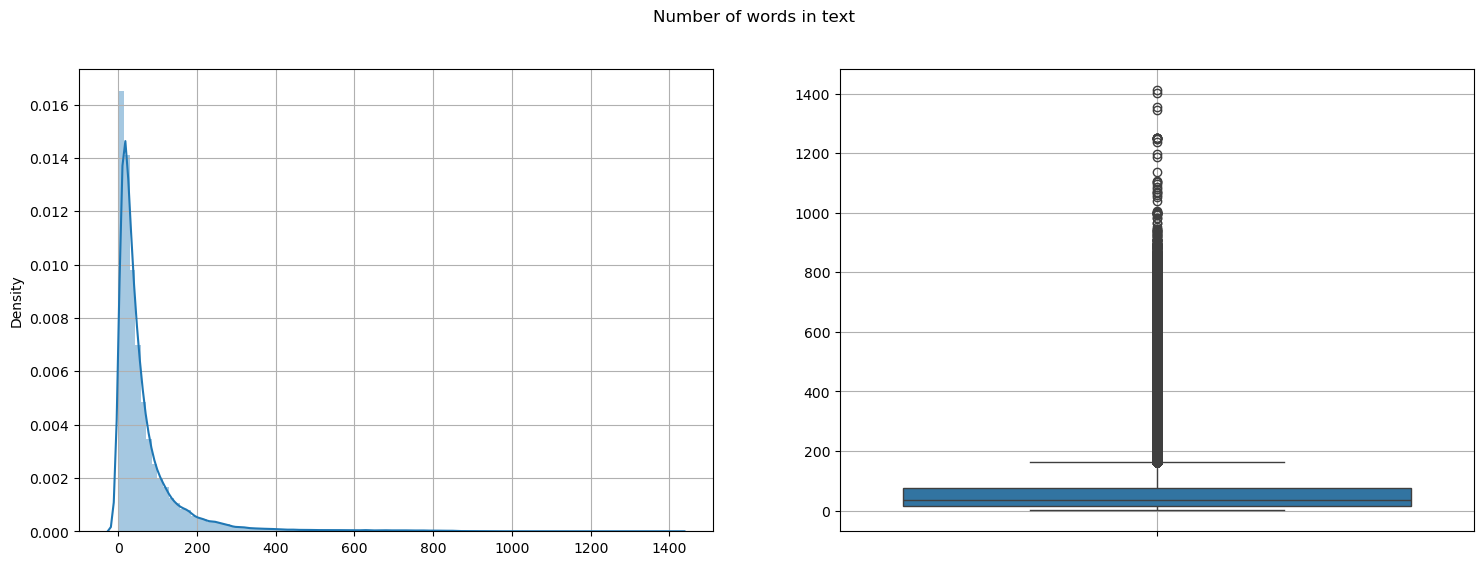

In [ ]:
analyze_words_number(data['text'])

In [ ]:
data['text'][140651]

'I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM 

**Обработаем комментарии**

In [ ]:
def preprocess_text(text):
    '''Preprocesses text: remove urls, punctuations (except '!?) and extra spaces, convert to lower case'''

    text = text.lower()                               # Convert to lowercase
    text = re.sub(r"https?://\S+|www\.\S+", "", text) # Remove URLs
    text = re.sub(r"[^a-z\s\'?!]", " ", text)         # Remove unwanted characters
    text = re.sub(r"\s+", " ", text).strip()          # Remove extra spaces

    return text

In [ ]:
data['text'] = data['text'].apply(preprocess_text)

In [ ]:
def remove_stopwords(text):
    stop = stopwords.words('english') + ['u', 'im']
    return ' '.join(word for word in text.split() if word not in stop)

In [ ]:
data_without_stop_words = data['text'].apply(remove_stopwords)

**Посмотрим какие слова встречаются чаще всего среди всех комментариев и отдельно среди токсичных**

In [ ]:
number_words = Counter()
for arr in data['text'].str.split().values:
    number_words.update(Counter(arr))

number_words_without_stop = Counter()
for arr in data_without_stop_words.str.split().values:
    number_words_without_stop.update(Counter(arr))

number_words_toxic = Counter()
for arr in data[data['toxic'] == 1]['text'].str.split().values:
    number_words_toxic.update(Counter(arr))

number_words_toxic_without_stop = Counter()
for arr in data_without_stop_words[data['toxic'] == 1].str.split().values:
    number_words_toxic_without_stop.update(Counter(arr))

In [ ]:
def create_table(*args):
    data = []
    for col in args:
        words_number = []
        for word, num in col.most_common(20):
            words_number.append(word)
        data.append(words_number)
    return pd.DataFrame(list(zip(*data)), columns=['number_words', 'number_words_without_stop', 'number_words_toxic', 'number_words_toxic_without_stop'])

In [ ]:
create_table(number_words, number_words_without_stop, number_words_toxic, number_words_toxic_without_stop)

,number_words,number_words_without_stop,number_words_toxic,number_words_toxic_without_stop
0,the,article,you,fuck
1,to,page,the,like
2,of,wikipedia,i,shit
3,and,talk,a,fucking
4,a,please,to,nigger
5,i,would,and,wikipedia
6,you,one,is,suck
7,is,like,of,go
8,that,see,your,hate
9,in,also,fuck,ass


**Как и ожидалось в комментариях без стопслов в топе по количеству употребления множество нецензурной лексики, но интересно еще и то, что в этих же комментариях со стопсловами наиболее часто использовалось слово you (рус. ты). Удалять стопслова из датасета не будем, так как так мы потеряем информацию и ухудшим результаты BERT**

**Посмотрим сколько раз повторяются уникальные слова в каждом отдельном комментарии**

In [ ]:
def count_words(text):
    _, counts = np.unique(text.split(), return_counts=True)
    return counts

In [ ]:
unique_words_number = np.concatenate(data['text'].apply(count_words).values)

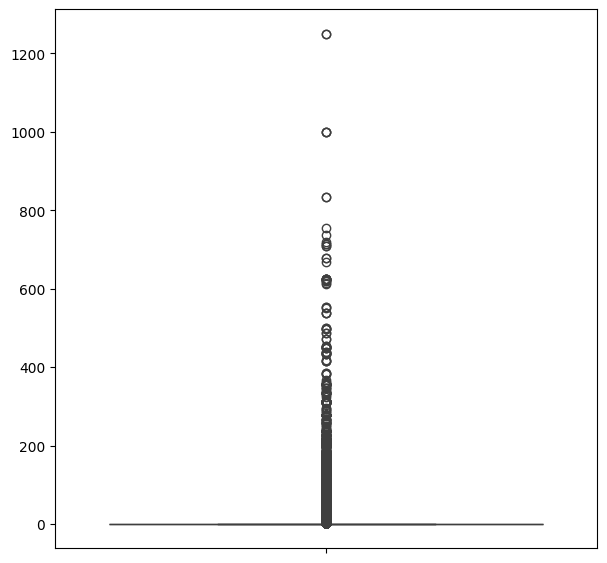

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(unique_words_number)
plt.show()

In [ ]:
np.quantile(unique_words_number, 0.9999)

84.0

**99.99% слов в комментариях повторяются не больше, чем 84 раза. Удалим все повторения больше этого**

In [ ]:
def remove_duplicated(text, max_occurrences=84):
    """Removes repeated words in a text, keeping up to max_occurrences of each word."""
    words = text.split()
    unique_words = []
    word_counts = {}

    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1
        if word_counts[word] <= max_occurrences:
            unique_words.append(word)

    return ' '.join(unique_words)

In [ ]:
data['text'] = data['text'].apply(remove_duplicated)

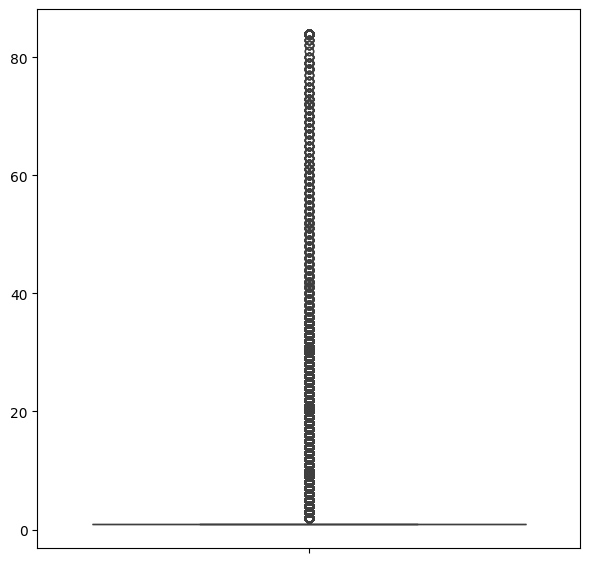

In [ ]:
unique_words_number = np.concatenate(data['text'].apply(count_words).values)

fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(unique_words_number)
plt.show()

Max number of word: 970

Text with max len
67715


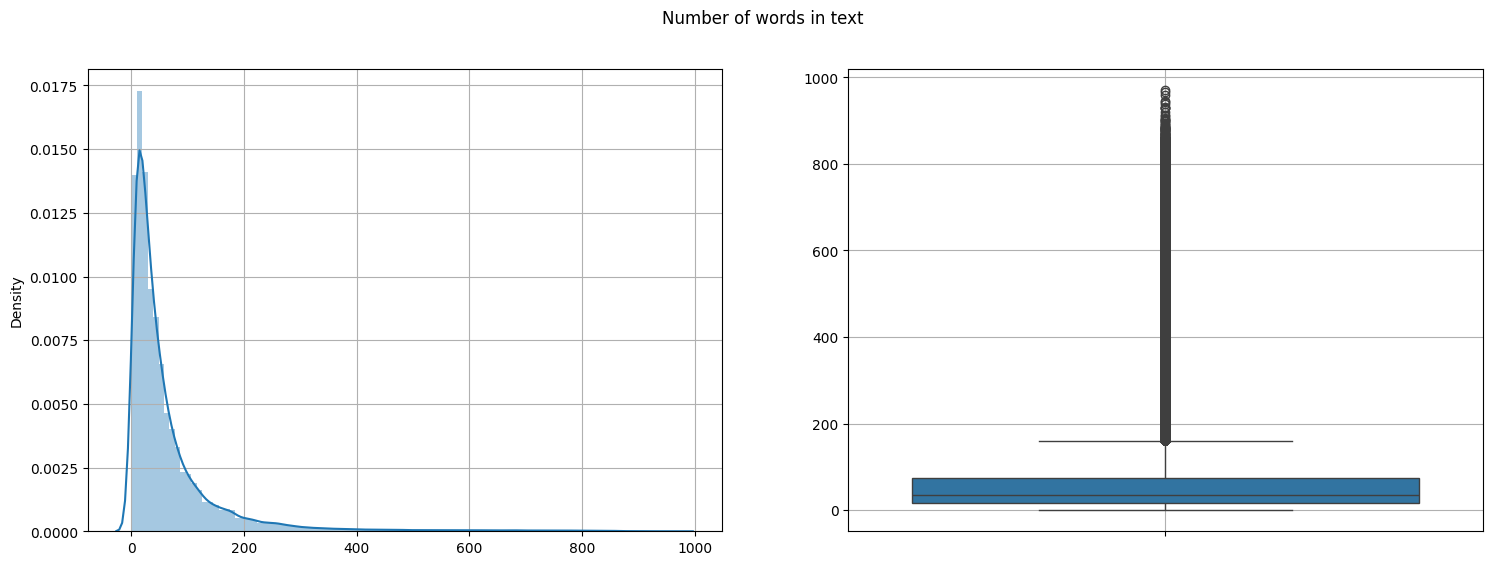

In [ ]:
analyze_words_number(data['text'])

In [ ]:
data['text'][67715]

"unblock everybodee im traviaan the nightmare d ive been busy irl so i havent been able to get to the computer much i hope you can understand now back to the task at hand now ive figured you all out kindness is the only way to win you over d kindness you shall get my fellow gentlemen ahh now you're really showing the love here and not a single piece of that wikipedia isn't the place for you mumbo jumbo guess travian is not the only one who has changed his attitude a bit now eh? d travian is glad hes glad i wasnt aggressive really not in the unblock requests anyway the rest was for pure unadulterated fun believe it or not but we will get to that part in a minute k? oh really? nothing i say huh? travian is sad so sad but he'll survive no not really it all stemmed from one thing to another you will see ill try to make you understand this in a most less confusing way as possible k? im reading it as we speak ill be on it in a few secs this reply is to jbw the following is to my fellow block

### Embeddings from BERT

**Воспользуемся предобученным BERT для создания эмбеддингов, а обучать на них будем Logistic Regression и Pytorch Sequential**

In [ ]:
PRE_TRAINED_MODEL_NAME = 'unitary/toxic-bert'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []

for txt in data['text']:
    tokens = tokenizer.encode(txt)
    token_lens.append(len(tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


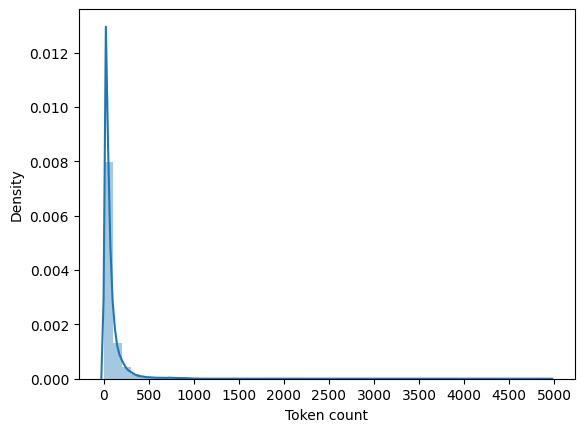

In [ ]:
sns.distplot(token_lens)
plt.xlabel('Token count')
plt.xticks(range(0, 5001, 500))
plt.show()

**В каких-то комментариях почти 5000 токенов, но большая часть имеет меньше 500, BERT рассчитан максимум на 512 токенов у одного объекта, поэтому будем ограничивать этим**

**Загрузим комментарии в torch.Dataset и воспользуемся torch.DataLoader для создания эмбеддингов по батчам. Эмбеддинги сохраним в список. Мы будем использовать \[CLS\] hidden state**

In [ ]:
bert_model = bert_model.to(device)

In [ ]:
class TextDataset(Dataset):

    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        target = self.targets[item]
        # create tokens
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': target
        }

In [ ]:
def create_data_loader(data, tokenizer, max_len, batch_size):

    ds = TextDataset(
        texts=data['text'].values,
        targets=data['toxic'].values,
        tokenizer=tokenizer,
        max_len=max_len,
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
    )

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 512
# divide dataset to train and test
train, test = train_test_split(data, test_size=0.1, stratify=data['toxic'], random_state=RANDOM_STATE)

dataloader_train = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
dataloader_test = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

embeddings_train = []
targets_train = []
embeddings_test = []
targets_test = []

In [ ]:
for d in notebook.tqdm(dataloader_train):
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets']

    with torch.no_grad():
        batch_embeddings = bert_model(input_ids, attention_mask=attention_mask)

    embeddings_train.append(batch_embeddings[0][:,0,:].to('cpu').numpy())
    targets_train.append(targets)

for d in notebook.tqdm(dataloader_test):
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets']

    with torch.no_grad():
        batch_embeddings = bert_model(input_ids, attention_mask=attention_mask)

    embeddings_test.append(batch_embeddings[0][:,0,:].to('cpu').numpy())
    targets_test.append(targets)

  0%|          | 0/8961 [00:00<?, ?it/s]

  0%|          | 0/996 [00:00<?, ?it/s]

In [ ]:
del bert_model, input_ids, attention_mask

In [ ]:
X_train = np.concatenate(embeddings_train)
X_test = np.concatenate(embeddings_test)
y_train = np.concatenate(targets_train)
y_test = np.concatenate(targets_test)

### Вывод

 - Во время подготовки данных был выявлен дисбаланс классов.
 - Текст комментариев обработан: удалены ссылки, все символы (кроме '!?), текст приведен к нижнему регистру, удалены лишние пробельные символы
 - Удалены повторения слов в одном комментарии превышающие 84 раза (99.99% слов в комментариях повторяются меньшее количество раз, при этом есть комментарии с многократным повтоением одной фразы)
 - Датасет разделен на обучающий и тестовый в соотношении 9:1
 - Созданы эмбеддинги для дальнейшей классификации с помощью предобученной модели 'unitary/toxic-bert'

## Обучение

### LogisticRegression

#### Oversample

**Для обучения и валидации моделей воспользуемся средствами библиотеки** `imblearn`**: Pipeline и оверсемплером SMOTE, чтобы избавиться от дисбаланса классов во время обучения.**

In [ ]:
# create pipeline with over-sampler and model
log_pipeline = Pipeline([['smote', SMOTE(random_state=RANDOM_STATE)],
                        ['log', LogisticRegression(random_state=RANDOM_STATE)]],
                       )
# cv splitter
kf = KFold(n_splits=5, shuffle=False)
param_log = {'log__C': np.logspace(-3, 3, 7)}

grid_log_SMOTE = GridSearchCV(log_pipeline, param_log, cv=kf, scoring='f1')

In [ ]:
grid_log_SMOTE.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=1)],
                                       ['log',
                                        LogisticRegression(random_state=1)]]),
             param_grid={'log__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1')

In [ ]:
print(f'F1: {grid_log_SMOTE.best_score_}\n'
      f'Best params: {grid_log_SMOTE.best_params_}'
)

F1: 0.8957634553254137
Best params: {'log__C': 1000.0}


#### Without Oversample

**Попробуем также обучить логистическую регрессию без SMOTE**

In [ ]:
log = LogisticRegression(random_state=RANDOM_STATE)
kf = KFold(n_splits=5, shuffle=False)
param_log = {'C': np.logspace(-3, 3, 7)}

grid_log = GridSearchCV(log, param_log, cv=kf, scoring='f1')

In [ ]:
grid_log.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=1),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1')

In [ ]:
print(f'F1: {grid_log.best_score_}\n'
      f'Best params: {grid_log.best_params_}'
)

F1: 0.9262896874553004
Best params: {'C': 0.1}


### Pytorch

In [ ]:
import gc


torch.cuda.empty_cache()
gc.collect()

653

**Разделим обучающую выборку на обучающую и валидационную для обучения нейронной сети**

In [ ]:
X_train_torch, X_val, y_train_torch, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=RANDOM_STATE)

**Посчитаем веса для 0 и 1 классов**

In [ ]:
class_wts = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights= torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)
weights

tensor([0.5566, 4.9208], device='cuda:0')

In [ ]:
class TextDataset(Dataset):

    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        target = self.targets[item]

        return {
            'texts': torch.tensor(text),
            'targets': torch.tensor(target, dtype=torch.float64)
        }
    def get_labels(self):
        return torch.tensor(self.targets, dtype=torch.float64)

In [ ]:
def create_data_loader(texts, targets, batch_size, sampler=False):

    ds = TextDataset(
        texts=texts,
        targets=targets,
    )
    if sampler:
        sampler = ImbalancedDatasetSampler(ds)
    else:
        sampler = None

    return DataLoader(
        ds,
        batch_size=batch_size,
        sampler=sampler,
    )

**Воспользуемся FocalLoss как функцией ошибки для обучения модели, так как у нас имеется дизбаланс классов, а эта функция помогает с ним бороться**

In [ ]:
class FocalLoss(nn.Module):

    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction = self.reduction
        )

In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    f1_score,
    acc
):
    model.train()

    losses = []

    for d in notebook.tqdm(data_loader):
        inputs = d["texts"].to(device)
        targets = d["targets"]
        targets = targets.type(torch.LongTensor).to(device)

        outputs = model(inputs)

        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # get predictions
        prediction = F.softmax(outputs, dim=1)[:, 1].flatten()
        # update f1 and accuracy
        f1_score.update(prediction, targets)
        acc.update(prediction, targets)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    # compute f1 and accuracy
    epoch_f1_score = f1_score.compute()
    f1_score.reset()
    epoch_acc = acc.compute()
    acc.reset()

    return epoch_f1_score, epoch_acc, np.mean(losses)

In [ ]:
def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    f1_score,
    acc,
):
    model.eval()

    losses = []

    with torch.no_grad():
        for d in data_loader:
            inputs = d["texts"].to(device)
            targets = d["targets"]
            targets = targets.type(torch.LongTensor).to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # get predictions
            prediction = F.softmax(outputs, dim=1)[:, 1].flatten()
            # update f1 and accuracy
            f1_score.update(prediction, targets)
            acc.update(prediction, targets)
    # compute f1 and accuracy
    eval_f1_score = f1_score.compute()
    f1_score.reset()
    epoch_acc = acc.compute()
    acc.reset()

    return eval_f1_score, epoch_acc, np.mean(losses)

**Используем средства библиотеки Optuna для подбора гиперпараметров**

In [ ]:
def create_model(trial, in_size):
    n_layers = trial.suggest_int("n_layers", 1, 3)

    layers = []
    for i in range(n_layers):
        n_units = trial.suggest_int(f"n_units_l{i}", 4, 512, log=True)
        dr = trial.suggest_float("dr", 0.1, 0.5, step=0.1)
        layers.append(nn.Linear(in_size, n_units))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dr))
        in_size = n_units
    layers.append(nn.Linear(in_size, 2))

    return nn.Sequential(*layers)

In [ ]:
def objective(trial):
    sampler = trial.suggest_categorical("sampler", [True, False])
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    epochs = trial.suggest_categorical("epochs", [2, 3])
    lr = trial.suggest_float("lr", 5e-6, 5e-4, log=True)
    gamma = trial.suggest_categorical("gamma", [0, 0.5, 1, 2, 3])
    weight = trial.suggest_categorical("weight", [True, False])

    train_data_loader = create_data_loader(X_train_torch, y_train_torch, batch_size,
                                           sampler=sampler,
                                           )
    val_data_loader = create_data_loader(X_val, y_val, batch_size)

    model = create_model(trial, 768).to(device)
    optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)
    total_steps = len(train_data_loader) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    if weight:
        loss_fn = FocalLoss(weight=weights, gamma=gamma).to(device)
    else:
        loss_fn = FocalLoss(weight=None, gamma=gamma).to(device)

    f1_score = BinaryF1Score().to(device)
    acc = BinaryAccuracy().to(device)


    for epoch in range(epochs):

        train_f1, train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            f1_score,
            acc
        )

        val_f1, val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
            f1_score,
            acc
        )
    return val_f1

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

[I 2024-01-30 17:00:09,325] A new study created in memory with name: no-name-c56809ff-9393-4add-a861-0d42ce187842


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:00:48,277] Trial 0 finished with value: 0.9149965643882751 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 8.278988327863377e-05, 'gamma': 0.5, 'weight': False, 'n_layers': 3, 'n_units_l0': 12, 'dr': 0.1, 'n_units_l1': 308, 'n_units_l2': 62}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 17:01:26,513] Trial 1 finished with value: 0.8729179501533508 and parameters: {'sampler': True, 'batch_size': 16, 'epochs': 2, 'lr': 1.0502294005668056e-05, 'gamma': 2, 'weight': False, 'n_layers': 1, 'n_units_l0': 20, 'dr': 0.5}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:01:49,896] Trial 2 finished with value: 0.8817272186279297 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 2, 'lr': 1.6826065279114723e-05, 'gamma': 3, 'weight': True, 'n_layers': 2, 'n_units_l0': 13, 'dr': 0.2, 'n_units_l1': 222}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:03:33,658] Trial 3 finished with value: 0.9033722877502441 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0002191799162022679, 'gamma': 2, 'weight': True, 'n_layers': 1, 'n_units_l0': 135, 'dr': 0.1}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:04:11,057] Trial 4 finished with value: 0.8772038221359253 and parameters: {'sampler': True, 'batch_size': 32, 'epochs': 3, 'lr': 8.410370434766547e-05, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 22, 'dr': 0.1, 'n_units_l1': 306}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:04:34,555] Trial 5 finished with value: 0.9134184122085571 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 2, 'lr': 0.00014859191396139664, 'gamma': 0.5, 'weight': False, 'n_layers': 2, 'n_units_l0': 19, 'dr': 0.1, 'n_units_l1': 97}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:05:09,745] Trial 6 finished with value: 0.8938670754432678 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.0002810392972064126, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 4, 'dr': 0.5, 'n_units_l1': 17}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:06:51,405] Trial 7 finished with value: 0.9135475158691406 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00041002222448465825, 'gamma': 0, 'weight': True, 'n_layers': 1, 'n_units_l0': 19, 'dr': 0.2}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:09:07,793] Trial 8 finished with value: 0.18450044095516205 and parameters: {'sampler': True, 'batch_size': 8, 'epochs': 3, 'lr': 1.0234206149664177e-05, 'gamma': 0.5, 'weight': True, 'n_layers': 3, 'n_units_l0': 168, 'dr': 0.30000000000000004, 'n_units_l1': 102, 'n_units_l2': 12}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:09:48,896] Trial 9 finished with value: 0.7254509329795837 and parameters: {'sampler': True, 'batch_size': 32, 'epochs': 3, 'lr': 0.00023931480243563074, 'gamma': 3, 'weight': True, 'n_layers': 3, 'n_units_l0': 60, 'dr': 0.5, 'n_units_l1': 25, 'n_units_l2': 69}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 17:10:36,587] Trial 10 finished with value: 0.9108079671859741 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 2, 'lr': 3.613689113848659e-05, 'gamma': 1, 'weight': False, 'n_layers': 3, 'n_units_l0': 419, 'dr': 0.4, 'n_units_l1': 6, 'n_units_l2': 235}. Best is trial 0 with value: 0.9149965643882751.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:12:18,272] Trial 11 finished with value: 0.9151415228843689 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0004537269697243206, 'gamma': 0, 'weight': True, 'n_layers': 1, 'n_units_l0': 6, 'dr': 0.2}. Best is trial 11 with value: 0.9151415228843689.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:14:01,971] Trial 12 finished with value: 0.9113416075706482 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 4.823546328851888e-05, 'gamma': 0, 'weight': True, 'n_layers': 1, 'n_units_l0': 4, 'dr': 0.2}. Best is trial 11 with value: 0.9151415228843689.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:16:14,643] Trial 13 finished with value: 0.9164955615997314 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00010184853116155485, 'gamma': 0, 'weight': False, 'n_layers': 3, 'n_units_l0': 8, 'dr': 0.30000000000000004, 'n_units_l1': 483, 'n_units_l2': 4}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:18:11,470] Trial 14 finished with value: 0.9013062715530396 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0004927510573118165, 'gamma': 0, 'weight': False, 'n_layers': 2, 'n_units_l0': 6, 'dr': 0.30000000000000004, 'n_units_l1': 4}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:20:24,455] Trial 15 finished with value: 0.9123159050941467 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00012425492586153703, 'gamma': 0, 'weight': True, 'n_layers': 3, 'n_units_l0': 8, 'dr': 0.4, 'n_units_l1': 72, 'n_units_l2': 5}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:22:06,717] Trial 16 finished with value: 0.9139966368675232 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 2.085566153713944e-05, 'gamma': 0, 'weight': True, 'n_layers': 1, 'n_units_l0': 36, 'dr': 0.30000000000000004}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:24:06,010] Trial 17 finished with value: 0.9119170904159546 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 5.9945743675809435e-06, 'gamma': 1, 'weight': False, 'n_layers': 2, 'n_units_l0': 9, 'dr': 0.4, 'n_units_l1': 13}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 17:24:43,691] Trial 18 finished with value: 0.873108983039856 and parameters: {'sampler': True, 'batch_size': 16, 'epochs': 2, 'lr': 8.693385387646238e-05, 'gamma': 0, 'weight': False, 'n_layers': 1, 'n_units_l0': 42, 'dr': 0.2}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:26:56,458] Trial 19 finished with value: 0.9146549105644226 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 3.2269287667459154e-05, 'gamma': 0, 'weight': True, 'n_layers': 3, 'n_units_l0': 6, 'dr': 0.2, 'n_units_l1': 452, 'n_units_l2': 4}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:28:55,320] Trial 20 finished with value: 0.9143619537353516 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00016677379549461029, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 104, 'dr': 0.30000000000000004, 'n_units_l1': 40}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:29:34,120] Trial 21 finished with value: 0.9164941906929016 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 7.799896365311117e-05, 'gamma': 0.5, 'weight': False, 'n_layers': 3, 'n_units_l0': 11, 'dr': 0.1, 'n_units_l1': 195, 'n_units_l2': 30}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:30:12,991] Trial 22 finished with value: 0.9119278788566589 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 6.0098693715809365e-05, 'gamma': 0.5, 'weight': False, 'n_layers': 3, 'n_units_l0': 7, 'dr': 0.2, 'n_units_l1': 165, 'n_units_l2': 25}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 17:31:24,216] Trial 23 finished with value: 0.9158620238304138 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00011081662030933613, 'gamma': 0.5, 'weight': False, 'n_layers': 3, 'n_units_l0': 12, 'dr': 0.1, 'n_units_l1': 464, 'n_units_l2': 284}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 17:32:36,083] Trial 24 finished with value: 0.916120171546936 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00011942163832828126, 'gamma': 0.5, 'weight': False, 'n_layers': 3, 'n_units_l0': 12, 'dr': 0.1, 'n_units_l1': 492, 'n_units_l2': 502}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 17:33:47,272] Trial 25 finished with value: 0.9153128862380981 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 5.3097024940362286e-05, 'gamma': 0.5, 'weight': False, 'n_layers': 3, 'n_units_l0': 29, 'dr': 0.1, 'n_units_l1': 171, 'n_units_l2': 17}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 17:35:00,584] Trial 26 finished with value: 0.18450044095516205 and parameters: {'sampler': True, 'batch_size': 16, 'epochs': 3, 'lr': 6.91350358697433e-05, 'gamma': 0.5, 'weight': False, 'n_layers': 3, 'n_units_l0': 71, 'dr': 0.30000000000000004, 'n_units_l1': 473, 'n_units_l2': 128}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 17:35:48,946] Trial 27 finished with value: 0.18450044095516205 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 2, 'lr': 3.599779039667094e-05, 'gamma': 0.5, 'weight': False, 'n_layers': 3, 'n_units_l0': 13, 'dr': 0.4, 'n_units_l1': 252, 'n_units_l2': 490}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:36:29,309] Trial 28 finished with value: 0.9120111465454102 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.0001992426186503551, 'gamma': 1, 'weight': False, 'n_layers': 3, 'n_units_l0': 4, 'dr': 0.1, 'n_units_l1': 138, 'n_units_l2': 9}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 17:37:41,364] Trial 29 finished with value: 0.915488064289093 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 9.198888110698085e-05, 'gamma': 0.5, 'weight': False, 'n_layers': 3, 'n_units_l0': 15, 'dr': 0.1, 'n_units_l1': 509, 'n_units_l2': 39}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:38:21,045] Trial 30 finished with value: 0.9163786172866821 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.0003246970541892338, 'gamma': 3, 'weight': False, 'n_layers': 3, 'n_units_l0': 30, 'dr': 0.2, 'n_units_l1': 57, 'n_units_l2': 144}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:39:00,499] Trial 31 finished with value: 0.9151955246925354 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00027382257273241294, 'gamma': 3, 'weight': False, 'n_layers': 3, 'n_units_l0': 9, 'dr': 0.2, 'n_units_l1': 54, 'n_units_l2': 129}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:39:40,231] Trial 32 finished with value: 0.9161779880523682 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.0003399465099948055, 'gamma': 3, 'weight': False, 'n_layers': 3, 'n_units_l0': 27, 'dr': 0.1, 'n_units_l1': 322, 'n_units_l2': 410}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:40:20,015] Trial 33 finished with value: 0.9146804809570312 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00035813512746451435, 'gamma': 3, 'weight': False, 'n_layers': 3, 'n_units_l0': 27, 'dr': 0.2, 'n_units_l1': 268, 'n_units_l2': 142}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:40:46,568] Trial 34 finished with value: 0.9148352146148682 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 2, 'lr': 0.0003318029463607853, 'gamma': 3, 'weight': False, 'n_layers': 3, 'n_units_l0': 59, 'dr': 0.1, 'n_units_l1': 122, 'n_units_l2': 215}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:41:23,927] Trial 35 finished with value: 0.8793050050735474 and parameters: {'sampler': True, 'batch_size': 32, 'epochs': 3, 'lr': 0.0001949683610799461, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 24, 'dr': 0.1, 'n_units_l1': 42}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:42:03,473] Trial 36 finished with value: 0.9157458543777466 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00015339492474320874, 'gamma': 3, 'weight': False, 'n_layers': 3, 'n_units_l0': 15, 'dr': 0.2, 'n_units_l1': 315, 'n_units_l2': 74}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:42:29,806] Trial 37 finished with value: 0.9122442603111267 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 2, 'lr': 2.4301549378452537e-05, 'gamma': 3, 'weight': False, 'n_layers': 3, 'n_units_l0': 34, 'dr': 0.1, 'n_units_l1': 193, 'n_units_l2': 36}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:43:05,152] Trial 38 finished with value: 0.9164628386497498 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.0003034387127287537, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 18, 'dr': 0.30000000000000004, 'n_units_l1': 343}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:43:42,597] Trial 39 finished with value: 0.8707692623138428 and parameters: {'sampler': True, 'batch_size': 32, 'epochs': 3, 'lr': 6.96993820060253e-05, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 17, 'dr': 0.30000000000000004, 'n_units_l1': 70}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:44:18,017] Trial 40 finished with value: 0.9162966012954712 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00025248154855090716, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 20, 'dr': 0.30000000000000004, 'n_units_l1': 347}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:44:53,286] Trial 41 finished with value: 0.9149600863456726 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.0002512959677257571, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 23, 'dr': 0.30000000000000004, 'n_units_l1': 357}. Best is trial 13 with value: 0.9164955615997314.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:45:28,755] Trial 42 finished with value: 0.9167240262031555 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00020385460331924884, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 11, 'dr': 0.30000000000000004, 'n_units_l1': 212}. Best is trial 42 with value: 0.9167240262031555.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:46:03,962] Trial 43 finished with value: 0.9137336015701294 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00013326300327092116, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 11, 'dr': 0.4, 'n_units_l1': 224}. Best is trial 42 with value: 0.9167240262031555.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:46:39,086] Trial 44 finished with value: 0.8987618684768677 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00018249415861694174, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 5, 'dr': 0.30000000000000004, 'n_units_l1': 221}. Best is trial 42 with value: 0.9167240262031555.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:47:14,313] Trial 45 finished with value: 0.9188078045845032 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.0004087610961598795, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 10, 'dr': 0.30000000000000004, 'n_units_l1': 29}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:47:37,763] Trial 46 finished with value: 0.9097902178764343 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 2, 'lr': 9.75501363996771e-05, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 9, 'dr': 0.30000000000000004, 'n_units_l1': 20}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:48:14,890] Trial 47 finished with value: 0.8639951348304749 and parameters: {'sampler': True, 'batch_size': 32, 'epochs': 3, 'lr': 0.0004100609900092669, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 10, 'dr': 0.4, 'n_units_l1': 29}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:48:46,346] Trial 48 finished with value: 0.910620391368866 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00021713592557178404, 'gamma': 2, 'weight': False, 'n_layers': 1, 'n_units_l0': 7, 'dr': 0.30000000000000004}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:50:45,279] Trial 49 finished with value: 0.9122807383537292 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00048276688208396564, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 16, 'dr': 0.4, 'n_units_l1': 14}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:51:20,394] Trial 50 finished with value: 0.9052251577377319 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00013754391086636831, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 5, 'dr': 0.30000000000000004, 'n_units_l1': 88}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:51:55,720] Trial 51 finished with value: 0.9157458543777466 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.0003141988390241091, 'gamma': 1, 'weight': False, 'n_layers': 2, 'n_units_l0': 19, 'dr': 0.30000000000000004, 'n_units_l1': 137}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:52:31,188] Trial 52 finished with value: 0.915032684803009 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00041731682596816267, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 479, 'dr': 0.30000000000000004, 'n_units_l1': 29}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 17:53:02,586] Trial 53 finished with value: 0.9132867455482483 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00030733152004049834, 'gamma': 2, 'weight': False, 'n_layers': 1, 'n_units_l0': 7, 'dr': 0.2}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:55:01,067] Trial 54 finished with value: 0.9169526696205139 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00022528157668617727, 'gamma': 0, 'weight': False, 'n_layers': 2, 'n_units_l0': 311, 'dr': 0.30000000000000004, 'n_units_l1': 387}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:56:59,859] Trial 55 finished with value: 0.9159068465232849 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00017547115647366084, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 289, 'dr': 0.30000000000000004, 'n_units_l1': 381}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 17:58:58,457] Trial 56 finished with value: 0.9162357449531555 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00010664307416384648, 'gamma': 0, 'weight': False, 'n_layers': 2, 'n_units_l0': 212, 'dr': 0.4, 'n_units_l1': 267}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:00:16,753] Trial 57 finished with value: 0.9126682877540588 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 2, 'lr': 7.290028817203625e-05, 'gamma': 0, 'weight': False, 'n_layers': 2, 'n_units_l0': 13, 'dr': 0.30000000000000004, 'n_units_l1': 10}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:02:17,127] Trial 58 finished with value: 0.8847236037254333 and parameters: {'sampler': True, 'batch_size': 8, 'epochs': 3, 'lr': 0.00022641917711767193, 'gamma': 0, 'weight': False, 'n_layers': 2, 'n_units_l0': 8, 'dr': 0.30000000000000004, 'n_units_l1': 372}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:04:15,474] Trial 59 finished with value: 0.9153689742088318 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 4.346912447021386e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 119, 'dr': 0.4, 'n_units_l1': 186}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:06:15,173] Trial 60 finished with value: 0.0 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0001564821870569539, 'gamma': 1, 'weight': False, 'n_layers': 2, 'n_units_l0': 5, 'dr': 0.5, 'n_units_l1': 406}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 18:06:50,556] Trial 61 finished with value: 0.9150190949440002 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00037227559061817707, 'gamma': 2, 'weight': False, 'n_layers': 2, 'n_units_l0': 59, 'dr': 0.30000000000000004, 'n_units_l1': 31}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 18:07:29,813] Trial 62 finished with value: 0.18450044095516205 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00028229306008168873, 'gamma': 0.5, 'weight': False, 'n_layers': 3, 'n_units_l0': 39, 'dr': 0.2, 'n_units_l1': 51, 'n_units_l2': 7}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:09:27,408] Trial 63 finished with value: 0.9142266511917114 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 1.1824587272615523e-05, 'gamma': 0, 'weight': False, 'n_layers': 2, 'n_units_l0': 11, 'dr': 0.30000000000000004, 'n_units_l1': 20}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 18:10:06,740] Trial 64 finished with value: 0.9113214015960693 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.0004981110406274823, 'gamma': 2, 'weight': False, 'n_layers': 3, 'n_units_l0': 49, 'dr': 0.2, 'n_units_l1': 275, 'n_units_l2': 20}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

  0%|          | 0/4033 [00:00<?, ?it/s]

[I 2024-01-30 18:10:42,063] Trial 65 finished with value: 0.18450044095516205 and parameters: {'sampler': False, 'batch_size': 32, 'epochs': 3, 'lr': 0.00023413799295220005, 'gamma': 0.5, 'weight': False, 'n_layers': 2, 'n_units_l0': 14, 'dr': 0.30000000000000004, 'n_units_l1': 102}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:12:56,329] Trial 66 finished with value: 0.9166380763053894 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00040235745473632964, 'gamma': 0, 'weight': False, 'n_layers': 3, 'n_units_l0': 17, 'dr': 0.2, 'n_units_l1': 158, 'n_units_l2': 12}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:15:09,796] Trial 67 finished with value: 0.915687620639801 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0003997071254663578, 'gamma': 0, 'weight': False, 'n_layers': 3, 'n_units_l0': 88, 'dr': 0.30000000000000004, 'n_units_l1': 218, 'n_units_l2': 13}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:17:07,804] Trial 68 finished with value: 0.9167230725288391 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0002694743128846185, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 8, 'dr': 0.2, 'n_units_l1': 155}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:18:36,743] Trial 69 finished with value: 0.9111111760139465 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 2, 'lr': 5.327963329389659e-06, 'gamma': 0, 'weight': True, 'n_layers': 3, 'n_units_l0': 8, 'dr': 0.2, 'n_units_l1': 176, 'n_units_l2': 7}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:20:37,529] Trial 70 finished with value: 0.8294796943664551 and parameters: {'sampler': True, 'batch_size': 8, 'epochs': 3, 'lr': 0.00020574708514348297, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 6, 'dr': 0.2, 'n_units_l1': 146}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:22:36,343] Trial 71 finished with value: 0.9163292646408081 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0002833415326016476, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 10, 'dr': 0.30000000000000004, 'n_units_l1': 294}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:24:34,676] Trial 72 finished with value: 0.9166101813316345 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 8.160648410444822e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 11, 'dr': 0.2, 'n_units_l1': 111}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:26:32,708] Trial 73 finished with value: 0.9155405759811401 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 8.003601339628054e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 8, 'dr': 0.2, 'n_units_l1': 111}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:28:30,969] Trial 74 finished with value: 0.9155645966529846 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 6.016534780859986e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 11, 'dr': 0.2, 'n_units_l1': 81}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:30:29,485] Trial 75 finished with value: 0.9148648977279663 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00010875536505340723, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 9, 'dr': 0.2, 'n_units_l1': 160}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:32:27,500] Trial 76 finished with value: 0.9154262542724609 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 5.716050511481733e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 13, 'dr': 0.1, 'n_units_l1': 134}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:34:41,194] Trial 77 finished with value: 0.9160149693489075 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 4.287545725920319e-05, 'gamma': 0, 'weight': True, 'n_layers': 3, 'n_units_l0': 7, 'dr': 0.2, 'n_units_l1': 430, 'n_units_l2': 28}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:36:39,248] Trial 78 finished with value: 0.9164969325065613 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 9.172679185082579e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 10, 'dr': 0.2, 'n_units_l1': 236}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:38:38,236] Trial 79 finished with value: 0.9164997339248657 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00012525984244648496, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 175, 'dr': 0.2, 'n_units_l1': 224}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:40:37,020] Trial 80 finished with value: 0.9163879752159119 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00012156055316859008, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 281, 'dr': 0.2, 'n_units_l1': 235}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:42:36,048] Trial 81 finished with value: 0.9163879752159119 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 9.331340052206582e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 164, 'dr': 0.2, 'n_units_l1': 200}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:44:34,874] Trial 82 finished with value: 0.9155495762825012 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00016146200576518577, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 255, 'dr': 0.2, 'n_units_l1': 307}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:46:32,973] Trial 83 finished with value: 0.9168081879615784 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 8.469268592605048e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 6, 'dr': 0.2, 'n_units_l1': 248}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:48:32,400] Trial 84 finished with value: 0.9142091274261475 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00013984739868023023, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 421, 'dr': 0.2, 'n_units_l1': 163}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:50:31,874] Trial 85 finished with value: 0.9175432920455933 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 8.774669802763685e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 6, 'dr': 0.2, 'n_units_l1': 236}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:52:30,381] Trial 86 finished with value: 0.9143824577331543 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 6.348007886990561e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 6, 'dr': 0.2, 'n_units_l1': 109}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:53:49,773] Trial 87 finished with value: 0.9149223566055298 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 2, 'lr': 0.00025225327454381257, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 5, 'dr': 0.2, 'n_units_l1': 206}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:55:51,312] Trial 88 finished with value: 0.799889087677002 and parameters: {'sampler': True, 'batch_size': 8, 'epochs': 3, 'lr': 0.00044236322175749245, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 4, 'dr': 0.2, 'n_units_l1': 127}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 18:56:55,232] Trial 89 finished with value: 0.8946195244789124 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 8.205406240288112e-05, 'gamma': 1, 'weight': True, 'n_layers': 2, 'n_units_l0': 197, 'dr': 0.2, 'n_units_l1': 35}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 18:58:54,878] Trial 90 finished with value: 0.9166101813316345 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0003608673831892179, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 387, 'dr': 0.2, 'n_units_l1': 151}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:00:54,082] Trial 91 finished with value: 0.916216254234314 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0003762919031913385, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 305, 'dr': 0.2, 'n_units_l1': 150}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:02:53,041] Trial 92 finished with value: 0.9150370359420776 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0001899445044203173, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 354, 'dr': 0.2, 'n_units_l1': 249}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:04:52,432] Trial 93 finished with value: 0.9159891605377197 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0003319533537942444, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 373, 'dr': 0.2, 'n_units_l1': 172}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:06:52,686] Trial 94 finished with value: 0.9159891605377197 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00026644655830934314, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 434, 'dr': 0.2, 'n_units_l1': 194}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:08:35,930] Trial 95 finished with value: 0.9154027700424194 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0004419596970385067, 'gamma': 0, 'weight': True, 'n_layers': 1, 'n_units_l0': 501, 'dr': 0.2}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:10:35,630] Trial 96 finished with value: 0.9153562784194946 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00011931070560101865, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 155, 'dr': 0.2, 'n_units_l1': 269}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:12:34,823] Trial 97 finished with value: 0.9147802591323853 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00021823674876139462, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 233, 'dr': 0.2, 'n_units_l1': 23}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:14:33,215] Trial 98 finished with value: 0.9146711230278015 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00034318065550021986, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 7, 'dr': 0.30000000000000004, 'n_units_l1': 113}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:15:28,227] Trial 99 finished with value: 0.8992297649383545 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.0003014110859592933, 'gamma': 0, 'weight': True, 'n_layers': 1, 'n_units_l0': 15, 'dr': 0.2}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:16:48,925] Trial 100 finished with value: 0.9078947305679321 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 2, 'lr': 0.000392967107441435, 'gamma': 1, 'weight': True, 'n_layers': 2, 'n_units_l0': 192, 'dr': 0.30000000000000004, 'n_units_l1': 64}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:18:47,850] Trial 101 finished with value: 0.9160460233688354 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 8.929024728003302e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 10, 'dr': 0.2, 'n_units_l1': 239}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:20:47,237] Trial 102 finished with value: 0.9170013070106506 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 9.461160024459478e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 332, 'dr': 0.2, 'n_units_l1': 89}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:22:46,678] Trial 103 finished with value: 0.9170567989349365 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 7.675229430049337e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 328, 'dr': 0.2, 'n_units_l1': 86}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:24:46,386] Trial 104 finished with value: 0.9159946441650391 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 4.8379986845958783e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 334, 'dr': 0.2, 'n_units_l1': 88}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:26:44,814] Trial 105 finished with value: 0.9017080068588257 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 7.462740798201453e-05, 'gamma': 2, 'weight': True, 'n_layers': 2, 'n_units_l0': 249, 'dr': 0.30000000000000004, 'n_units_l1': 78}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:28:43,118] Trial 106 finished with value: 0.8081769347190857 and parameters: {'sampler': True, 'batch_size': 8, 'epochs': 3, 'lr': 6.938859451699474e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 419, 'dr': 0.2, 'n_units_l1': 121}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:30:39,242] Trial 107 finished with value: 0.9155734777450562 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.0001045453988460737, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 320, 'dr': 0.30000000000000004, 'n_units_l1': 98}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:32:36,937] Trial 108 finished with value: 0.9045912623405457 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.000357204001343996, 'gamma': 2, 'weight': True, 'n_layers': 2, 'n_units_l0': 378, 'dr': 0.1, 'n_units_l1': 49}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:34:32,815] Trial 109 finished with value: 0.916469395160675 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 6.522396442090144e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 12, 'dr': 0.2, 'n_units_l1': 146}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:36:27,779] Trial 110 finished with value: 0.9099368453025818 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 3.035361211712382e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 6, 'dr': 0.2, 'n_units_l1': 4}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:38:23,786] Trial 111 finished with value: 0.9164438247680664 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 8.353953940151037e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 462, 'dr': 0.2, 'n_units_l1': 156}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:40:18,889] Trial 112 finished with value: 0.9145559072494507 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00010137644892452235, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 9, 'dr': 0.2, 'n_units_l1': 94}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:42:15,286] Trial 113 finished with value: 0.9156626462936401 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 5.427512682130671e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 388, 'dr': 0.2, 'n_units_l1': 182}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:44:10,731] Trial 114 finished with value: 0.9154694080352783 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 0.00012651971132241185, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 260, 'dr': 0.2, 'n_units_l1': 67}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

  0%|          | 0/16129 [00:00<?, ?it/s]

[I 2024-01-30 19:46:05,938] Trial 115 finished with value: 0.9155495762825012 and parameters: {'sampler': False, 'batch_size': 8, 'epochs': 3, 'lr': 8.037370893484129e-05, 'gamma': 0, 'weight': True, 'n_layers': 2, 'n_units_l0': 85, 'dr': 0.2, 'n_units_l1': 128}. Best is trial 45 with value: 0.9188078045845032.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:47:08,105] Trial 116 finished with value: 0.9189560413360596 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00014173780281799572, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 289, 'dr': 0.2, 'n_units_l1': 298}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:48:10,328] Trial 117 finished with value: 0.9173808097839355 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00014018636460925033, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 223, 'dr': 0.30000000000000004, 'n_units_l1': 300}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:49:12,628] Trial 118 finished with value: 0.9169526696205139 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.0001415459571159381, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 228, 'dr': 0.30000000000000004, 'n_units_l1': 300}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:49:54,145] Trial 119 finished with value: 0.9159519672393799 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 2, 'lr': 0.000143901273597201, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 224, 'dr': 0.30000000000000004, 'n_units_l1': 323}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:50:58,502] Trial 120 finished with value: 0.8738876581192017 and parameters: {'sampler': True, 'batch_size': 16, 'epochs': 3, 'lr': 0.00017004586483789494, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 275, 'dr': 0.30000000000000004, 'n_units_l1': 410}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:52:00,822] Trial 121 finished with value: 0.9173241257667542 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00015623864883793743, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 299, 'dr': 0.30000000000000004, 'n_units_l1': 289}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:53:03,256] Trial 122 finished with value: 0.9167523384094238 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00015195371078304906, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 293, 'dr': 0.30000000000000004, 'n_units_l1': 279}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:54:05,495] Trial 123 finished with value: 0.9186405539512634 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.0001829615833674851, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 308, 'dr': 0.30000000000000004, 'n_units_l1': 292}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:55:08,040] Trial 124 finished with value: 0.9174374938011169 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.0001579665116550163, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 315, 'dr': 0.30000000000000004, 'n_units_l1': 293}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:56:10,235] Trial 125 finished with value: 0.918826699256897 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00015387533768537786, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 331, 'dr': 0.30000000000000004, 'n_units_l1': 292}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:57:12,410] Trial 126 finished with value: 0.9182905554771423 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00017450728332276059, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 337, 'dr': 0.30000000000000004, 'n_units_l1': 340}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:58:14,638] Trial 127 finished with value: 0.9182003736495972 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00016655027553310003, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 333, 'dr': 0.30000000000000004, 'n_units_l1': 348}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 19:59:16,733] Trial 128 finished with value: 0.9180551171302795 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00016566250418059857, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 336, 'dr': 0.30000000000000004, 'n_units_l1': 466}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:00:18,993] Trial 129 finished with value: 0.9172931909561157 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00017435133687368866, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 332, 'dr': 0.30000000000000004, 'n_units_l1': 511}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:01:21,469] Trial 130 finished with value: 0.9156378507614136 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.0001799704696490518, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 339, 'dr': 0.30000000000000004, 'n_units_l1': 337}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:02:23,853] Trial 131 finished with value: 0.9176068902015686 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00016495835132875582, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 345, 'dr': 0.30000000000000004, 'n_units_l1': 363}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:03:25,959] Trial 132 finished with value: 0.9179540276527405 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00015877732650801258, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 307, 'dr': 0.30000000000000004, 'n_units_l1': 473}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:04:27,766] Trial 133 finished with value: 0.9187713861465454 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00016589728410060283, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 264, 'dr': 0.30000000000000004, 'n_units_l1': 501}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:05:29,715] Trial 134 finished with value: 0.9179540276527405 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00016149432204915694, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 272, 'dr': 0.30000000000000004, 'n_units_l1': 451}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:06:31,765] Trial 135 finished with value: 0.9160358309745789 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00019682408312483344, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 267, 'dr': 0.30000000000000004, 'n_units_l1': 469}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:07:34,131] Trial 136 finished with value: 0.9166380763053894 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00016542000378806304, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 247, 'dr': 0.30000000000000004, 'n_units_l1': 437}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:08:36,464] Trial 137 finished with value: 0.9177193641662598 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00013091181867218977, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 408, 'dr': 0.30000000000000004, 'n_units_l1': 373}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:09:39,015] Trial 138 finished with value: 0.9187158942222595 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00018981959696717012, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 370, 'dr': 0.30000000000000004, 'n_units_l1': 366}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:10:41,722] Trial 139 finished with value: 0.9164941906929016 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00011642247039224472, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 437, 'dr': 0.30000000000000004, 'n_units_l1': 370}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:11:43,751] Trial 140 finished with value: 0.9186046719551086 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.0001871386027081734, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 373, 'dr': 0.30000000000000004, 'n_units_l1': 461}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:12:45,811] Trial 141 finished with value: 0.9176631569862366 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00019139884102437236, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 372, 'dr': 0.30000000000000004, 'n_units_l1': 440}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:13:48,301] Trial 142 finished with value: 0.9180102944374084 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00020334640316936421, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 368, 'dr': 0.30000000000000004, 'n_units_l1': 461}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:14:50,703] Trial 143 finished with value: 0.9173241257667542 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00019751398160324822, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 388, 'dr': 0.30000000000000004, 'n_units_l1': 455}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:15:53,052] Trial 144 finished with value: 0.9169526696205139 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00018099717291869527, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 496, 'dr': 0.30000000000000004, 'n_units_l1': 412}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:16:55,858] Trial 145 finished with value: 0.9181786775588989 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00020922631948253962, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 405, 'dr': 0.30000000000000004, 'n_units_l1': 500}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:17:59,765] Trial 146 finished with value: 0.9186046719551086 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.00021822511490591197, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 410, 'dr': 0.30000000000000004, 'n_units_l1': 496}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:19:03,421] Trial 147 finished with value: 0.9171497225761414 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 3, 'lr': 0.0002368359801103047, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 279, 'dr': 0.30000000000000004, 'n_units_l1': 511}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:19:46,047] Trial 148 finished with value: 0.9179205894470215 and parameters: {'sampler': False, 'batch_size': 16, 'epochs': 2, 'lr': 0.00021046881395034815, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 461, 'dr': 0.30000000000000004, 'n_units_l1': 466}. Best is trial 116 with value: 0.9189560413360596.


  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

  0%|          | 0/8065 [00:00<?, ?it/s]

[I 2024-01-30 20:20:51,922] Trial 149 finished with value: 0.8702290058135986 and parameters: {'sampler': True, 'batch_size': 16, 'epochs': 3, 'lr': 0.0002254382784539121, 'gamma': 3, 'weight': False, 'n_layers': 2, 'n_units_l0': 363, 'dr': 0.30000000000000004, 'n_units_l1': 341}. Best is trial 116 with value: 0.9189560413360596.


In [ ]:
print('Best F1: ', study.best_value)
print('Best hyperparams:')
study.best_params

Best F1:  0.9189560413360596
Best hyperparams:


{'sampler': False,
 'batch_size': 16,
 'epochs': 3,
 'lr': 0.00014173780281799572,
 'gamma': 3,
 'weight': False,
 'n_layers': 2,
 'n_units_l0': 289,
 'dr': 0.2,
 'n_units_l1': 298}

**Так же как и с линейной регрессией, лучший результат показала модель, не использущая ни веса, ни семплинг. Создадим модель с похожими гиперпараметрами и посмотрим на результат валидации**

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(X_train_torch, y_train_torch, BATCH_SIZE)
val_data_loader = create_data_loader(X_val, y_val, BATCH_SIZE)
test_data_loader = create_data_loader(X_test, y_test, BATCH_SIZE)

In [ ]:
class ToxicClassifier(nn.Module):

    def __init__(self):
        super(ToxicClassifier, self).__init__()
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.2)
        self.relu1 =  nn.ReLU()
        self.relu2 =  nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.out = nn.Linear(256, 2)

    def forward(self, inputs):
        output = self.fc1(inputs)
        output = self.relu1(output)
        output = self.drop1(output)
        output = self.fc2(output)
        output = self.relu2(output)
        output = self.drop2(output)
        return self.out(output)

In [ ]:
model = ToxicClassifier()
model = model.to(device)

In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=1e-4, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = FocalLoss(weight=None, gamma=3).to(device)
f1 = BinaryF1Score().to(device)
acc = BinaryAccuracy().to(device)

In [ ]:
history = defaultdict(list)

for epoch in notebook.tqdm(range(EPOCHS)):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 9)

    train_f1, train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        f1,
        acc
    )

    print(f'Train loss: {train_loss}; f1-score: {train_f1}; acc: {train_acc}')

    val_f1, val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        f1,
        acc
    )

    print(f'Val loss: {val_loss}; f1-score: {val_f1}; acc: {val_acc}')
    print()

    history['train_f1'].append(train_f1.item())
    history['train_loss'].append(train_loss.item())
    history['val_f1'].append(val_f1.item())
    history['val_loss'].append(val_loss.item())


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
---------


  0%|          | 0/8065 [00:00<?, ?it/s]

Train loss: 0.0062375667788341855; f1-score: 0.9218569993972778; acc: 0.9841890931129456
Val loss: 0.006332561750840164; f1-score: 0.9203354716300964; acc: 0.9840970635414124

Epoch 2/3
---------


  0%|          | 0/8065 [00:00<?, ?it/s]

Train loss: 0.005813438700893053; f1-score: 0.9252736568450928; acc: 0.9848711490631104
Val loss: 0.005967366853420291; f1-score: 0.920427143573761; acc: 0.9838878512382507

Epoch 3/3
---------


  0%|          | 0/8065 [00:00<?, ?it/s]

Train loss: 0.005586646631197085; f1-score: 0.92702317237854; acc: 0.9852043986320496
Val loss: 0.005859523020184514; f1-score: 0.9206458330154419; acc: 0.9838878512382507



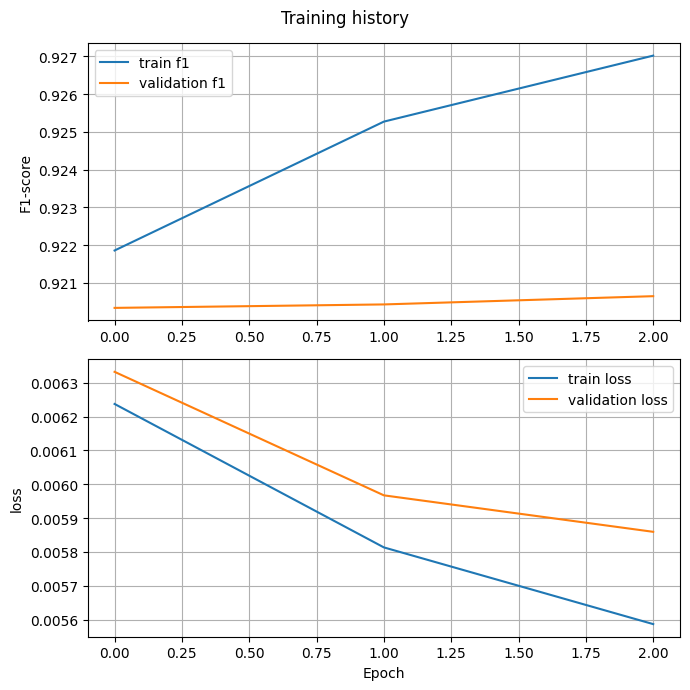

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7))
fig.suptitle('Training history')

sns.lineplot(history['train_f1'], label='train f1', ax=axs[0])
sns.lineplot(history['val_f1'], label='validation f1', ax=axs[0])

sns.lineplot(history['train_loss'], label='train loss', ax=axs[1])
sns.lineplot(history['val_loss'], label='validation loss', ax=axs[1])

axs[0].set_ylabel('F1-score')
axs[1].set_ylabel('loss')
plt.xlabel('Epoch')
axs[0].grid()
axs[1].grid()
plt.legend()
plt.tight_layout()
plt.show()

### Вывод

| Model | F1-score |
| ----- | -------- |
| Logistic Regression with SMOTE | 0.8958 |
| Logistic Regression without SMOTE | 0.9263 |
| Pytorch Sequential Neural Network | 0.9206 |

**На валидации лучше себя показала Logistic Regression без SMOTE. Протестируем ее.**

## Тестирование

In [ ]:
predicntions = grid_log.predict(X_test)
f1_score(y_test, predicntions)

0.9243126351560085

In [ ]:
# sanity check
dummy = DummyClassifier(strategy = 'constant', constant = 1)
dummy.fit(X_train, y_train)
f1_score(y_test, dummy.predict(X_test))

0.18451193800216537

## Вывод

1. При изучении выявлен дисбаланс классов, но впоследствии выяснилось, что качество модели это не ухудшает.

2. Комментарии были обработаны: приведены к нижнему регистру, удалены ссылки и лишние символы, удалены повторения слов в одном комментарии больше, чем 84 (так как были комментарии, состоящие из многократного повторения одной и той же фразы)

3. Для классификации тектов были созданы эмбеддинги с помощью предобученной модели 'unitary/toxic-bert'

4. Для обучения ипользовались LogisticRegression и Pytorch Sequential Neural Network. Лучше себя на валидации показала LogisticRegression без техники оверсемплинга. На тестировании использовали эту модель, получено значение F1-score 0.9243.

Заданное значение метрики (F1 > 0.75) достигнуто. Для наиболее оптимального решения рекомендуем модель LogisticRegression, она показала лучший результат по метрике и оптимальна по затратам времени.